# Exploratory Data Analysis

After gathering and processing initial data, the next step is to conduct exploratory data anlaysis. We would like to examine which predictors include useful information. EDA will further enlighten us on the modelling process as well. 

In [1]:
import random
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Imputer
import math

In [2]:
green_col = np.divide([30,215,96],255)
black_col = [0,0,0]
gray_col = np.divide([150,150,150],255)
light_gray_col = np.divide([236,235,232],255)
white_col =  np.divide([255,255,255],255)
med_gray_col = np.divide([80,80,80],255)

colors = [green_col, black_col, gray_col, light_gray_col, white_col]

afont = {'fontname':'AppleGothic'}
hfont = {'fontname':'Helvetica'}
ifont = {'fontname': 'Impact'}
arfont = {'fontname': 'Arial'}
ofont = {'fontname': 'Osaka'}
sfont = {'fontname': 'STHeiti'}
hirafont = {'fontname': 'Hiragino Kaku Gothic ProN'}

In [3]:
sns.set_style('whitegrid')

## Predictor Variables

First, we would like to examine the dataframe for any problematic or duplicate columns. Then, we split the dataframe into training and test set. The size of the training set and test set is shown below.

In [4]:
data= pd.read_csv('data/Final_Dataframe.csv')

In [5]:
# A train/test split is constructed where 90% of the subsample is 
# the train data set and 10% the test data set.

# Set train and test sizes
train_size = 0.9
test_size = 1-train_size

# Function to return random train and test sets
def data_splitter(df, train, validate=False, seed=9001):
    
    if validate:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        validate_end = int(validate * m) + train_end
        train = df.ix[perm[:train_end]]
        validate = df.ix[perm[train_end:validate_end]]
        test = df.ix[perm[validate_end:]]
        return train, validate, test
    else:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        train = df.ix[perm[:train_end]]
        test = df.ix[perm[train_end:]]
        return train, test

In [6]:
# Create train and test dataframes from subsample
train_df, test_df = data_splitter(data, train_size)

# Return shapes of train and test dataframes
print("Train Size: {}".format(train_df.shape))
print("Test Size: {}".format(test_df.shape))

Train Size: (1278, 950)
Test Size: (142, 950)


In [7]:
# Find Missing Columns
null_vals = train_df.isnull().sum()
missing_vals = null_vals[null_vals > 0].index.tolist() 

In [8]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
train_df = pd.DataFrame(imp.fit_transform(train_df), columns=data.columns)
test_df = pd.DataFrame(imp.transform(test_df), columns=data.columns)

In [9]:
# Split training and test data
train_df = train_df[train_df['Followers'] != 0]
test_df = test_df[test_df['Followers'] != 0]

In [10]:
# Final step: create y_train/x_train and y_test/x_test dataframes

# Initialize the training data
y_train = np.log(train_df['Followers'])
x_train = train_df.drop('Followers', axis=1)

# Initialize the testing data
y_test = np.log(test_df['Followers'])
x_test = test_df.drop('Followers', axis=1)

In [11]:
numerical_columns = []
top_artist_count_columns = []
genre_columns = []

for i in data.columns:
    
    if 'mean' in i or 'std' in i:
        numerical_columns.append(i)
    elif i[:2]=='to':
        top_artist_count_columns.append(i)
    elif (i[0].isalpha()==False and i[0]!=2):
        genre_columns.append(i)


title_columns = ['Str_Best','Str_Workout','Str_Party','Str_Chill','Str_Acoustic','Str_2000s','Str_1990s','Str_1980s',
                'Str_1970s','Str_1960s']

interaction_columns = ['house_acousticness_mean','hip hop_acousticness_std','pop_liveness_std','dance_liveness_std',
                      'r&b_acousticness_std','rap_energy_std','rap_key_std','acoustic_acousticness_std','acoustic_acousticness_mean',
                      'acoustic_energy_std','acoustic_key_std','soul_acousticness_std']

artist_columns = list(set(data.columns)-set(numerical_columns)-set(title_columns)-set(interaction_columns)-
                      set(top_artist_count_columns)-set(genre_columns))

In [12]:
# Extracting numerical columns
numerical_columns = []
for i in train_df.columns:
    if 'mean' in i or 'std' in i:
        numerical_columns.append(i)
        if (train_df[[i]].values==0).all():
            train_df = train_df.drop([i], axis=1)
            test_df = test_df.drop([i], axis=1)

# The numerical columns are standardized next
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean)/std

## Response Variable

The response variable is the number of followers for individual playlists. We note that some playlists have an extremely large number of followers, leading to a higly right skewed distribution of the response variable. To address the right skewness, a log transformation iss applied and the playlists with no followers are discarded. As can be seen by the figure below, logging the number of followers creates a relatively normal distribution. In addition, performing a log trasnformation helps with visualizing the data, modelling and making predictions. 

In [13]:
before_transform = np.exp(y_train)

def hist_response():
    f, axarr = plt.subplots(1,2, figsize=(15,8))

    sns.distplot(before_transform, color = black_col, ax = axarr[0])
    axarr[0].set_xlabel('Followers', fontsize=12, **arfont, color = med_gray_col)
    axarr[0].set_ylabel('Counts',fontsize=12, **arfont, color = med_gray_col)
    axarr[0].set_title('Followers (Before Log)', fontsize = 22, color=gray_col)
    
    sns.distplot(y_train, color = black_col, ax = axarr[1])
    axarr[1].set_xlabel('Log Followers', fontsize=12, **arfont, color = med_gray_col)
    axarr[1].set_ylabel('Counts',fontsize=12, **arfont, color = med_gray_col)
    axarr[1].set_title('Followers (After Log)', fontsize = 22, color=gray_col)

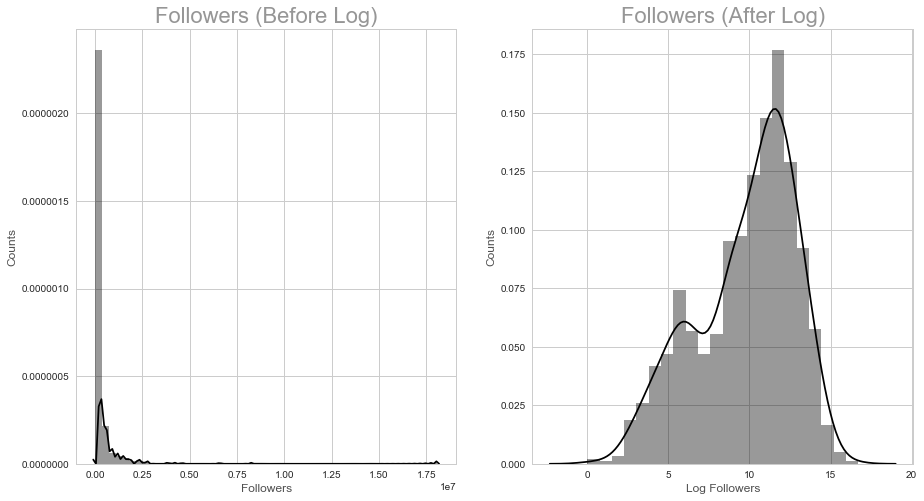

In [14]:
hist_response()

## Audio Features

Audio features are available on Spotify for each track. In total, eleven audio features are extracted for each track. For each playlist, the means and standard deviations of those features across the tracks in the playlist are used. 


These features are descriptors of the audio signals of each track. The full list of audio features and explanations for each are available here: 
https://developer.spotify.com/web-api/get-audio-features/


Descriptions for some important features are shown below:

**Energy:** Energy is measured on a scale from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks are fast, loud, and noisy.

**Liveness:** Liveness refers to the presence of an audience in the recording.

**Tempo:** Tempo isthe overall estimated tempo of a track in beats per minute (BPM).

**Valence:** Valence is measured on a scale from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence represent postive mood (e.g. happy, cheerful, euphoric), while tracks with low valence represent more negative mood(e.g. sad, depressed, angry).


When viewed in scatterplots against the response variable, certain features seem to contain more useful information. In particular, it seems that songs with high liveness (in which we can hear an audience in the recording)and songs with high valence (positive sounding) tend to have fewer followers.

In [15]:
plot_feats = ['energy_mean','valence_mean','acousticness_mean', 'liveness_mean',
              'key_mean']
plot_feats2 = ['energy_std','valence_std','acousticness_std', 'liveness_std','key_std']

line_plot = []

for i in range(len(plot_feats)):
    feat = plot_feats[i]
    
    y = np.log(y_train[y_train>0])
    x = x_train[feat][y_train>0]
    z = np.polyfit(x,y, 1)
    p = np.poly1d(z)
    
    x_plot = np.linspace(0, 1, 30)

    line_plot.append((feat, x_plot, p(x_plot)))
    
line_plot_df= pd.DataFrame(line_plot, columns = ['feat','x','y']).set_index('feat')

line_plot2 = []
for i in range(len(plot_feats2)):
    feat = plot_feats2[i]
    y = np.log(y_train[y_train>0])
    x = x_train[feat][y_train>0]
    z = np.polyfit(x,y, 1)
    p = np.poly1d(z)
    
    x_plot = np.linspace(0, 25, 30)

    line_plot2.append((feat, x_plot, p(x_plot)))
    
line_plot_df2= pd.DataFrame(line_plot2, columns = ['feat','x','y']).set_index('feat')

In [17]:
# pip install plotly
# pip install pandas_datareader
import plotly
plotly.__version__
plotly.tools.set_credentials_file(username='tingnoble', api_key='4zOe1ds7duZr15VxaRBp')

import plotly.plotly as py
import plotly.graph_objs as go 

from datetime import datetime
#import pandas_datareader as web
y_train_log = np.log(y_train)

energy_mean = go.Scatter(x=x_train['energy_mean'],
                        y=y_train_log,
                         xaxis = 'energy mean',
                        name='energy_mean',
                        mode = 'markers',
                        marker=dict(color='#062d14'))

energy_mean_line = go.Scatter(x =line_plot_df['x']['energy_mean'],
                         y = line_plot_df['y']['energy_mean'],
                        xaxis = 'energy mean',
                         name = 'energy_mean',
                         line = dict(color = '#ADA7A5'))

valence_mean = go.Scatter(x=x_train['valence_mean'],
                        y=y_train_log,
                        name='valence_mean',
                        mode = 'markers',
                        marker=dict(color='#0c5a27'))

valence_mean_line = go.Scatter(x =line_plot_df['x']['valence_mean'],
                         y = line_plot_df['y']['valence_mean'],
                         name = 'valence_mean',
                         line = dict(color = '#ADA7A5'))

acousticness_mean = go.Scatter(x=x_train['acousticness_mean'],
                        y=y_train_log,
                        name='acousticness_mean',
                        mode = 'markers',
                        marker=dict(color='#1ed760'))

acousticness_mean_line = go.Scatter(x =line_plot_df['x']['acousticness_mean'],
                         y = line_plot_df['y']['acousticness_mean'],
                         name = 'acousticness_mean',
                         line = dict(color = '#ADA7A5')
)

liveness_mean = go.Scatter(x=x_train['liveness_mean'],
                        y=y_train_log,
                        name='liveness_mean',
                        mode = 'markers',
                        marker=dict(color='4be782'))

liveness_mean_line = go.Scatter(x =line_plot_df['x']['liveness_mean'],
                         y = line_plot_df['y']['liveness_mean'],
                         name = 'liveness_mean',
                         line = dict(color = '#ADA7A5')
)

key_mean = go.Scatter(x=x_train['key_mean'],
                        y=y_train_log,
                        name='key_mean',
                        mode = 'markers',
                        marker=dict(color='#a5f3c0'))

key_mean_line = go.Scatter(x =line_plot_df['x']['key_mean'],
                         y = line_plot_df['y']['key_mean'],
                         name = 'key_mean',
                         line = dict(color = '#ADA7A5')
)


data1 = [energy_mean, energy_mean_line, valence_mean, valence_mean_line, acousticness_mean,acousticness_mean_line,
         liveness_mean,liveness_mean_line, key_mean,key_mean_line]

updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'energy_mean',
                 method = 'update',
                 args = [{'visible': [True,True, False, False, False,False, False, False,False, False]},
                         {'title': 'energy Mean',
                          }]),
             dict(label = 'valence_mean',
                 method = 'update',
                 args = [{'visible': [False, False, True, True, False,False, False, False,False, False]},
                         {'title': 'valence mean',
                          }]),
             dict(label = 'acousticness_mean',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True,True, False, False,False, False]},
                         {'title': 'acousticness mean',
                          }]),
             dict(label = 'liveness_mean',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False,False, True, True,False, False]},
                         {'title': 'liveness mean',
                          }]),
             dict(label = 'key_mean',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False,False, False, False,True, True]},
                         {'title': 'key mean',
                          }]),
        ]),
             )
])

layout = go.Layout(title='Audio Features (Mean)', 
              showlegend=False,
              updatemenus=updatemenus,
              xaxis=dict(
              range=[0,1],
              title = 'Audio Feature'
                ),
                yaxis=dict(
                title = 'Followers (log)'
                    )
                     )

fig = go.Figure(data=data1, layout=layout)


py.iplot(fig, filename='eda1')

In [18]:
# pip install plotly
# pip install pandas_datareader
import plotly
plotly.__version__
plotly.tools.set_credentials_file(username='tingnoble', api_key='4zOe1ds7duZr15VxaRBp')

import plotly.plotly as py
import plotly.graph_objs as go 

#from datetime import datetime
#import pandas_datareader as web
y_train_log = np.log(y_train)

energy_std = go.Scatter(x=x_train['energy_std'],
                        y=y_train_log,
                         xaxis = 'energy std',
                        name='energy_std',
                        mode = 'markers',
                        marker=dict(color='#062d14'))

energy_std_line = go.Scatter(x =line_plot_df2['x']['energy_std'],
                         y = line_plot_df2['y']['energy_std'],
                        xaxis = 'energy std',
                         name = 'energy_std',
                         line = dict(color = '#ADA7A5'))

valence_std = go.Scatter(x=x_train['valence_std'],
                        y=y_train_log,
                        name='valence_std',
                        mode = 'markers',
                        marker=dict(color='#0c5a27'))

valence_std_line = go.Scatter(x =line_plot_df2['x']['valence_std'],
                         y = line_plot_df2['y']['valence_std'],
                         name = 'valence_std',
                         line = dict(color = '#ADA7A5'))

acousticness_std = go.Scatter(x=x_train['acousticness_std'],
                        y=y_train_log,
                        name='acousticness_std',
                        mode = 'markers',
                        marker=dict(color='#1ed760'))

acousticness_std_line = go.Scatter(x =line_plot_df2['x']['acousticness_std'],
                         y = line_plot_df2['y']['acousticness_std'],
                         name = 'acousticness_std',
                         line = dict(color = '#ADA7A5')
)

liveness_std = go.Scatter(x=x_train['liveness_std'],
                        y=y_train_log,
                        name='liveness_std',
                        mode = 'markers',
                        marker=dict(color='#4be782'))

liveness_std_line = go.Scatter(x =line_plot_df2['x']['liveness_std'],
                         y = line_plot_df2['y']['liveness_std'],
                         name = 'liveness_std',
                         line = dict(color = '#ADA7A5')
)

key_std = go.Scatter(x=x_train['key_std'],
                        y=y_train_log,
                        name='key_std',
                        mode = 'markers',
                        marker=dict(color='#a5f3c0'))

key_std_line = go.Scatter(x =line_plot_df2['x']['key_std'],
                         y = line_plot_df2['y']['key_std'],
                         name = 'key_std',
                         line = dict(color = '#ADA7A5')
)


data1 = [energy_std, energy_std_line, valence_std, valence_std_line, acousticness_std,acousticness_std_line,
         liveness_std,liveness_std_line, key_std,key_std_line]

updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'energy_std',
                 method = 'update',
                 args = [{'visible': [True,True, False, False, False,False, False, False,False, False]},
                         {'title': 'energy standard deviation',
                          }]),
             dict(label = 'valence_std',
                 method = 'update',
                 args = [{'visible': [False, False, True, True, False,False, False, False,False, False]},
                         {'title': 'valence standard deviation',
                          }]),
             dict(label = 'acousticness_std',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True,True, False, False,False, False]},
                         {'title': 'acousticness standard deviation',
                          }]),
             dict(label = 'liveness_std',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False,False, True, True,False, False]},
                         {'title': 'liveness standard deviation',
                          }]),
             dict(label = 'key_std',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False,False, False, False,True, True]},
                         {'title': 'key standard deviation',
                          }]),
        ]),
             )
])

layout = go.Layout(title='Audio Features (Standard Deviations)', 
              showlegend=False,
              updatemenus=updatemenus,
              xaxis=dict(
              title = 'Audio Feature',
              range = [0, 10]
                ),
                yaxis=dict(
                title = 'Followers (log)'
                    )
                     )

fig = go.Figure(data=data1, layout=layout)


py.iplot(fig, filename='eda2')

## Genre Features

Genre features describe the genres of songs in the playlist. The following bar chart shows the average number of playlist followers for the most common genres in our training data. Common genres refer to the the genres that many playlists fall under.  All of these common genres have at least 200,000 followers, which is at the high end of the spectrum. In particular, we find out that **r&b** has the highest number of mean followers.

In [19]:
train_df['Followers_log'] = np.log(train_df['Followers'])

In [20]:
genres_counts = pd.DataFrame(np.zeros((len(genre_columns),4)), 
                             columns=['Num_tracks','Mean_Follow','Total_Follow','Std_Follow'])
genres_counts.index = genre_columns

for pred in genre_columns:
    
    pred_cols = train_df[train_df[pred]==1]
    follow = pred_cols['Followers']
    mean_followers = np.mean(follow[follow>0])
    total_followers = sum(follow)
    
    genres_counts['Num_tracks'][pred] = sum(train_df[pred])
    genres_counts['Mean_Follow'][pred] = round(mean_followers)
    genres_counts['Total_Follow'][pred] = round(total_followers)
    genres_counts['Std_Follow'][pred]= np.std(follow[follow>0])

genres_counts = genres_counts.sort_values(['Mean_Follow'], ascending=False)
genres_counts = genres_counts[(genres_counts['Mean_Follow']>200000)]
genres_counts_sub = genres_counts[genres_counts['Num_tracks']>900]
genres_counts_sub2 = genres_counts[genres_counts['Num_tracks']>500]


In [21]:
genres_counts_sub = genres_counts[genres_counts['Num_tracks']>700]
genres_counts_sub2 = genres_counts[genres_counts['Num_tracks']>500]


In [24]:
color_bars = ["#000000", '#062d14',"#0c5a27","#12873b","#18b44f","#1ed760","4be782",
              "#78eda1","#a5f3c0","#d2f9e0","#a5f3c0","#78eda1", "4be782", "#1ed760",
             "#18b44f","#12873b","#0c5a27", '#062d14',"#0c5a27","#12873b","#18b44f",
             "#1ed760","4be782","#78eda1","#a5f3c0","#d2f9e0","#a5f3c0","#78eda1"]
trace0 = go.Bar(
    x=genres_counts_sub.index.tolist(),
    y=genres_counts_sub['Mean_Follow'],
    text= ["Number of Tracks: " + str(x) for x in genres_counts_sub['Num_tracks']],
    marker=dict(
        color=color_bars,
        line=dict(
            color='#000000',
            width=1.5,
        )
    ),
    opacity=0.6
)

data1 = [trace0]
layout = go.Layout(
    title='Mean Followers of Common Genres',
)

fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='eda3')

In [25]:
worst_5 = genres_counts_sub2[len(genres_counts_sub2)-5:len(genres_counts_sub2)]
best_5 = genres_counts_sub2[:5]

worst_5_dict = dict()
for i in worst_5.index:
    idx = train_df[train_df[i]==1]
    worst_5_dict[i] =  np.log(idx['Followers'])

best_5_dict = dict()
for i in best_5.index:
    idx = train_df[train_df[i]==1]
    best_5_dict[i] =  np.log(idx['Followers'])

worst_5 = [x for x in worst_5_dict.keys()]
best_5 = [x for x in best_5_dict.keys()]

The following interactive histogram allows you to view different distributions of log Followers for different genres. The button on the left is for unpopular genres, while the button on the right is for popular genres. We can see that distributions are generally all left skewed. We also see that certain genres have many tracks (counts are high), but the number of followers per track may not be high, affecting their mean followers. We see a distinction between popularity and commonality/frequency of appearance of different genres. 

In [27]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

best1 = go.Histogram(
    x=best_5_dict[best_5[0]],
    name='popular:'+ best_5[0],
    opacity=0.4,
    marker = dict(color = '#062d14')
)
best2 = go.Histogram(
    x=best_5_dict[best_5[1]],
    name='popular: '+ best_5[1],
    opacity=0.4,
    marker = dict(color = '#062d14')
)
best3 = go.Histogram(
    x=best_5_dict[best_5[2]],
    name='popular:'+ best_5[2],
    marker = dict(color = '#062d14'),
    opacity=0.4
)
best4 = go.Histogram(
    x=best_5_dict[best_5[3]],
    name='popular:' + best_5[3],
    marker = dict(color = '#062d14'),
    opacity=0.4
)
best5 = go.Histogram(
    x=best_5_dict[best_5[4]],
    name='popular: '+ best_5[4],
    marker = dict(color = '#062d14'),
    opacity=0.4
)
worst1 = go.Histogram(
    x=worst_5_dict[worst_5[0]],
    name='unpopular: ' + worst_5[0],
    marker = dict(color = '#78eda1'),
    opacity=0.4
)
worst2 = go.Histogram(
    x=worst_5_dict[worst_5[1]],
    name='unpopular: ' + worst_5[1],
    marker = dict(color = '#78eda1'),
    opacity=0.4
)
worst3 = go.Histogram(
    x=worst_5_dict[worst_5[2]],
    name='unpopular: ' + worst_5[2],
    marker = dict(color = '#78eda1'),
    opacity=0.4
)
worst4 = go.Histogram(
    x=worst_5_dict[worst_5[3]],
    name='unpopular: ' + worst_5[3],
    marker = dict(color = '#78eda1'),
    opacity=0.4
)
worst5 = go.Histogram(
    x=worst_5_dict[worst_5[4]],
    name='unpopular: ' + worst_5[4],
    marker = dict(color = '#78eda1'),
    opacity=0.4
)


updatemenus = list([
    dict(
         buttons=list([
             dict(
        label = best_5[0],
             method = 'update',
             args = [{'visible': [True, False, False, False, False, False, False, False, False, False]},
                     
                    ]),
             dict(
        label = best_5[1],
             method = 'update',
             args = [{'visible': [False, True, False, False, False, False, False, False, False, False]},
                
                    ]),
             dict(
        label = best_5[2],
             method = 'update',
             args = [{'visible': [False, False, True, False, False, False, False, False, False, False]},
                
                    ]),
             dict(
        label = best_5[3],
             method = 'update',
             args = [{'visible': [False, False, False,True, False, False, False, False, False, False]},
                 
                    ]),
             dict(
        label = best_5[4],
             method = 'update',
             args = [{'visible': [False, False, False, False, True, False, False, False, False, False]},
                  
                    ])
           ]),   
        x = 0.55,
        y = 1.12  
    ),
    dict(
        buttons = list([
            dict(label = worst_5[0],
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True, False, False, False, False]},
                        
                        ]),
            dict(label = worst_5[1],
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, True, False, False, False]},
                         
                        ]),
            dict(label = worst_5[2],
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, True, False, False]},
                         
                        ]),
            dict(label = worst_5[3],
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, True, False]},
                         
                        ]),
            dict(label = worst_5[4],
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, False, False, False, True]},
                         
                        ])
        ]),
        x = 0.3,
        y = 1.12
    )
])
    


data3 = [best1, best2, best3, best4, best5, worst1, worst2, worst3, worst4, worst5]
layout = go.Layout(title = 'Distribution of Playlist Followers for Genres With Few/Many Mean Followers',
                   barmode='overlay', 
                   showlegend=True,
                  updatemenus = updatemenus,
                  xaxis = dict(
                      title = 'Playlist Followers (log)',
                      range = [0,16]),
                  yaxis = dict(
                  title = 'Counts',
                  range = [0,100]))
                  
fig = go.Figure(data=data3, layout=layout)

py.iplot(fig, filename='eda4')

### Interactions Between Genres and Audio Features

Interaction terms could potentially provide useful insight between genres and audio features. These could help answer questions such as: would the number of followers differ for different levels of 'danceability' for dance music vs. rap music? Because the number of genres exceed 100, the genres are first binned into broad genres such as 'house','hip hop','pop','dance','r&b','rap','acoustic','soul'. Then interaction terms are created with these broader genres. 

The following scatterplots and histograms show how audio features differ between two different genres: rap music and dance music. We observe see that their distributions differ (slightly). For example, rap music seems to be slightly higher in mean energy, and pop music seems to have a slightly higher valence. 

In [31]:
data_broad_genres = pd.read_csv('All_Data.csv')

In [32]:
## Further Preliminary Analysis ##

# Create train and test dataframes from subsample
train_df2, test_df2 = data_splitter(data_broad_genres, train_size)

# Return shapes of train and test dataframes
print("Train Size: {}".format(train_df.shape))
print("Test Size: {}".format(test_df.shape))

Train Size: (1257, 951)
Test Size: (139, 950)


In [33]:
## Further Preliminary Analysis ##

# The numerical columns are standardized next
mean = train_df2[numerical_columns].mean()
std = train_df2[numerical_columns].std()

train_df2[numerical_columns] = (train_df2[numerical_columns] - mean)/std
test_df2[numerical_columns] = (test_df2[numerical_columns] - mean)/std

In [34]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
train_df2 = pd.DataFrame(imp.fit_transform(train_df2), columns=data_broad_genres.columns)
test_df2 = pd.DataFrame(imp.transform(test_df2), columns=data_broad_genres.columns)

In [35]:
def plot_genre_audio(df, numeric_col, binary_col, colors):
    
    f, axarr = plt.subplots(len(numeric_col),2,figsize=(15,30))
    
    sample_n= int(min(df[binary_col][df[binary_col]!=0].sum(axis=0)))
    

    sample_n = min(sample_n, 900)
    
    for i in range(len(numeric_col)):
        #leg = axarr[i].get_legend()
        
        for j in range(len(binary_col)):
        #m = i%3
        #n = math.floor(i/3)
        
            curr_binary_col = df[df[binary_col[j]]==1].index
            
            samp = random.sample(curr_binary_col.tolist(),  sample_n)
        
            curr_numeric_col = df[numeric_col[i]][samp]
        
            curr_followers = df['Followers_log'][samp]
        
            axarr[i,0].scatter(curr_numeric_col,curr_followers, s = 15, color = colors[j], alpha = 0.5, label=binary_col[j])
            axarr[i,0].legend(fontsize=15)
            axarr[i,0].set_facecolor(white_col)
            axarr[i,0].set_title(numeric_col[i].replace("_"," ") + " vs Followers", fontsize = 20, color = gray_col)
            axarr[i,0].set_xlabel(numeric_col[i].replace("_"," "), fontsize=14, color = med_gray_col)
            axarr[i,0].set_ylabel('Log Followers',fontsize=14, color = med_gray_col)
            
            axarr[i,1].hist(curr_numeric_col.dropna(inplace=False), color = colors[j], alpha = 0.5, bins=20)
            axarr[i,1].set_facecolor(white_col)
            axarr[i,1].set_title('Histogram of ' + numeric_col[i].replace("_"," "), fontsize=20,  color = gray_col)
            axarr[i,0].set_xlabel(numeric_col[i].replace("_"," "), fontsize=14, color = med_gray_col)

In [36]:
num_cols = ['energy_mean','energy_std','valence_mean','valence_std']
genre = ['rap','dance']

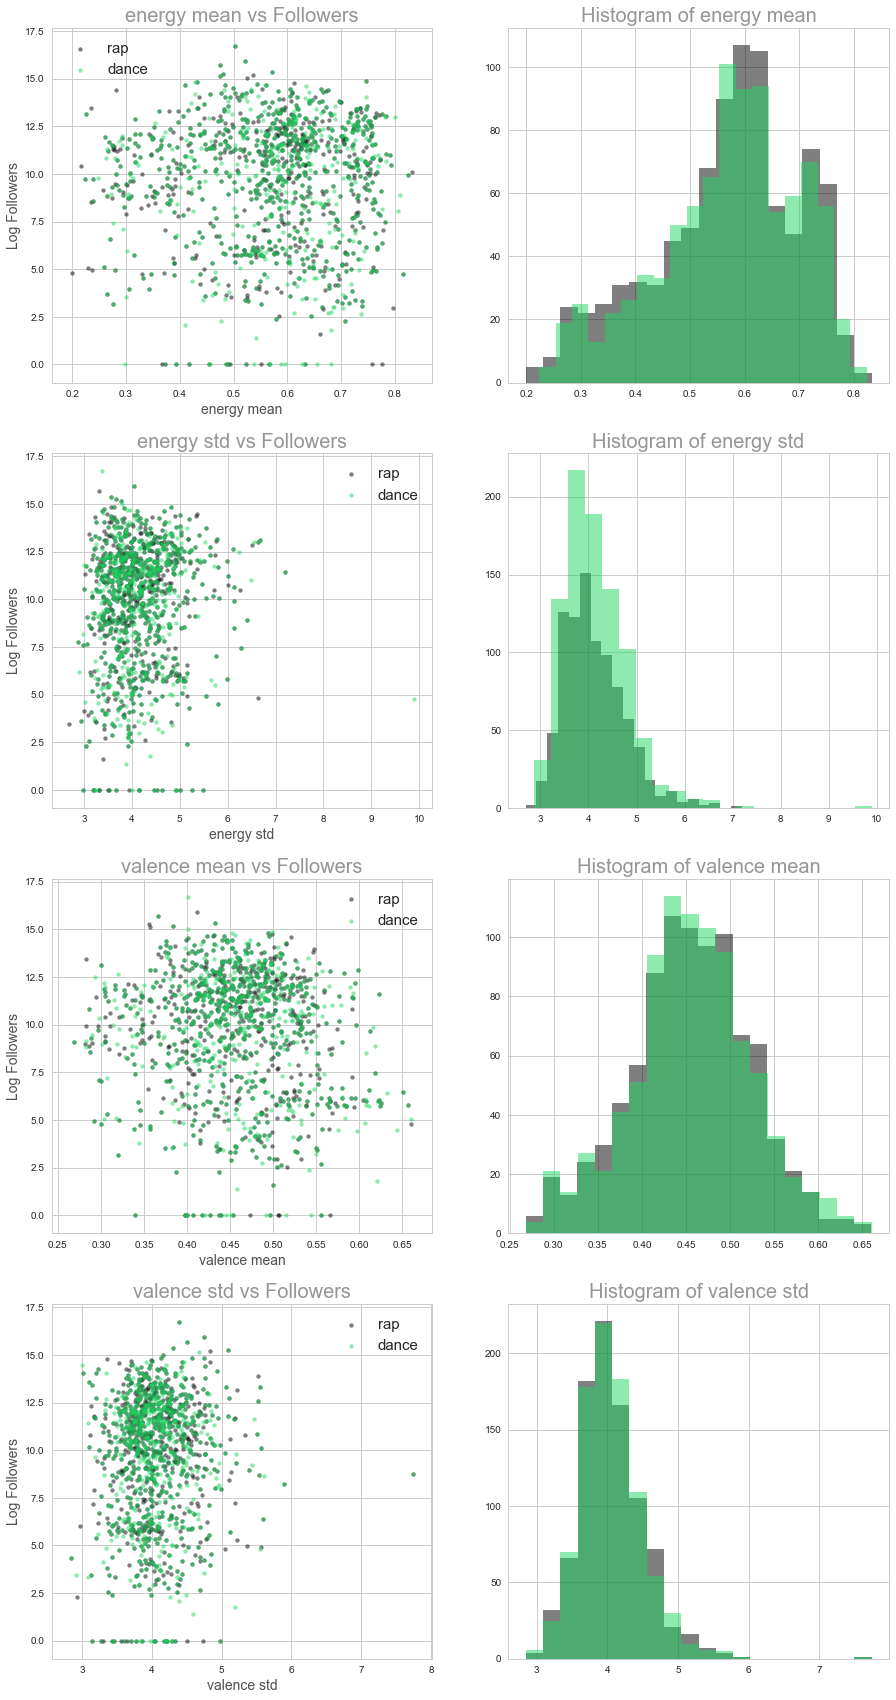

In [37]:
cols = [black_col, green_col]
plot_genre_audio(data_broad_genres, num_cols, genre, cols)

## Artist Features

We think that the presence of  artists who appear most often in popular playlists would be a good predictor for playlist success. To evaluate a playlist's popularity, we found out that a playlist with 35,000+ followers beat 80% of playlist in terms of followers. Therefore, we use 35,000+ as a benchmark. In the following graph, we examine the frequency of the artists appear in playlists with 35,000+playlists. We select the top 30 that appear most often as predictors. 

In [39]:
artist_followers_df=pd.read_csv('data/artist_level_EDA.csv')

In [40]:
popular_playlist=artist_followers_df[artist_followers_df['playlist followers'] >350000]
highartist=popular_playlist['artist'].value_counts()[1:30]
popular_artists=highartist.index.values
popular_artists

array(['Yo Gotti', 'Lil Wayne', 'Axwell /\\ Ingrosso', 'Otis Redding',
       'Wiz Khalifa', 'Van Morrison', 'A$AP Rocky', '21 Savage',
       'Galantis', 'Chance The Rapper', 'Rihanna', 'JAY Z', 'Post Malone',
       'Led Zeppelin', 'Young Thug', 'Ty Dolla $ign', 'Nicki Minaj',
       'Adele', 'Deorro', 'Kanye West', 'John Mayer', 'Diddy', 'SYML',
       'Ryan Adams', 'Commodores', 'Ellie Goulding', 'Birdy', 'SZA',
       'Miguel'], dtype=object)

In [41]:
followers_popular_artists=[]
for ele in popular_artists:
    followers_popular_artists.append(artist_followers_df[artist_followers_df.artist==ele]['playlist followers'].mean())

In [42]:
follower_artist_dic = dict(zip(popular_artists,followers_popular_artists))
import operator
sorted_x = sorted(follower_artist_dic.items(), key=operator.itemgetter(1))
popular_artists=[]
followers_popular_artists=[]
for ele in sorted_x:
    popular_artists.append(ele[0])
    followers_popular_artists.append(ele[1])

In [43]:
popular_artists.reverse()
followers_popular_artists.reverse()

In [44]:
color_bars = [ '#062d14',"#0c5a27","#12873b","#18b44f","#1ed760","4be782",
              "#78eda1","#a5f3c0","#d2f9e0","#a5f3c0","#78eda1", "4be782", "#1ed760",
             "#18b44f","#12873b","#0c5a27",'#062d14','#062d14',"#0c5a27",
             "#12873b","#18b44f","#1ed760","4be782","#78eda1","#a5f3c0","#d2f9e0","#a5f3c0",
             "#78eda1", "4be782", "#1ed760"]
trace0 = go.Bar(
    x=popular_artists,
    y=followers_popular_artists,
    marker=dict(
        color=color_bars,
        line=dict(
            color='#000000',
            width=1.5,
        )
    ),
    opacity=0.6
)

data1 = [trace0]
layout = go.Layout(
    title='Mean Followers For Playlists with Top 30 Artists',
)

fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='eda5')

Then, we average the number of followers for all playlists that include a top 30 artist. We would like to examine whether playlists including such artists are indeed more popular. From the following graph, we can see that 80% of the time, the presense of a top 30 artist leads to an average playlist followers of over 40,0000, demonstrating that these artists are indeed potentially good predictors for playlist success.

In [45]:
highartist = popular_playlist['artist'].value_counts(ascending=True)[8168:8198]
highartist = pd.DataFrame(highartist).reset_index()
highartist = highartist.sort_values(by ='artist', ascending=False)

In [59]:
color_bars = [ '#062d14'] + ["#18b44f"]*15 + ["#78eda1"]*14

trace0 = go.Bar(
    x=highartist['index'],
    y=highartist['artist'],
    marker=dict(
        color=color_bars,
        line=dict(
            color='#000000',
            width=1.5,
        )
    ),
    opacity=0.6
)

data1 = [trace0]
layout = go.Layout(
    title='Most Frequently Appeared 30 Artists in Playlists with 350,000+ Followers',
)

fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='eda6')

In [47]:
def mean_artist():
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    ax[0].scatter(train_df[train_df.Followers<200000]['popularity_mean'].values,
              train_df[train_df.Followers<200000]['Followers'].values,color = green_col)
    ax[0].set_title('Log Followers vs the Mean Artist Popularity',fontsize = 18, color = med_gray_col)
    ax[0].set_xlabel('Mean popularity score of artists', fontsize=12, **arfont, color = med_gray_col)
    ax[0].set_ylabel('Playlist followers (log scale)', fontsize=12, **arfont, color = med_gray_col)

    ax[1].scatter(train_df[(train_df.Followers<200000) ]['followers_mean'].values,
              train_df[(train_df.Followers<200000) ]['Followers'].values,color = green_col)
    ax[1].set_title('Log Followers vs the Mean Artist Followers',fontsize = 18, color = med_gray_col)
    ax[1].set_xlabel('Average number of followers for artists', fontsize=12, **arfont, color = med_gray_col)
    ax[1].set_ylabel('Playlist followers (log scale)', fontsize=12, **arfont, color = med_gray_col)


    plt.show()

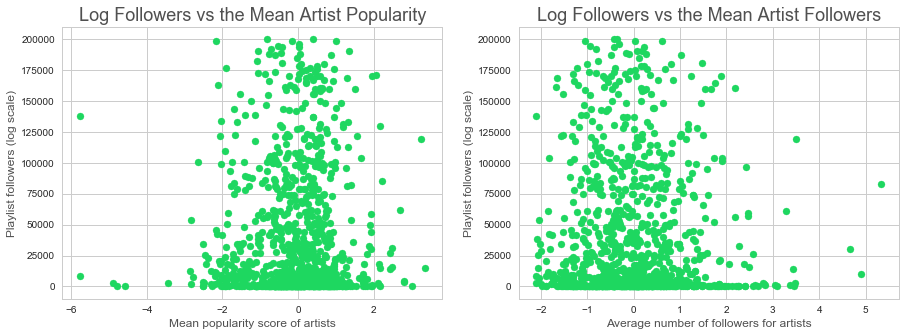

In [48]:
mean_artist()

## Title Features

The last categories that were explored were the titles of the playlists. Spotify users commonly search for certain words in playlist titles, such as "Best of 2017" or "Top Pop Music." Titles were parsed to find certain substrings which were common in titles, and then categorized. For example, the titles containing "top" and "best" belong to the same category (Best). Titles containing "motivation", "exercise", or "workout" were all categorized as workout song titles. The following chart shows the mean followers for these different title categories. It is clear that the "Best" category has a high number of mean followers whereas the older songs of the 20th century have a low number of mean followers. 

In [49]:
title_counts = pd.DataFrame(np.zeros((len(title_columns),4)), 
                             columns=['Num_tracks','Mean_Follow','Total_Follow','Std_Follow'])
title_counts.index = title_columns



print("Counts for Significant Titles: \n")

for pred in title_columns:
    
    pred_cols = train_df[train_df[pred]==1]
    mean_followers = np.mean(pred_cols['Followers'])
    total_followers = sum(pred_cols['Followers'])
    
    title_counts['Num_tracks'][pred] = sum(train_df[pred])
    title_counts['Mean_Follow'][pred] = round(mean_followers)
    title_counts['Total_Follow'][pred] = round(total_followers)
    title_counts['Std_Follow'][pred] = np.std(pred_cols['Followers'])

title_counts = title_counts.sort_values(['Mean_Follow'], ascending=False)
print(title_counts)

Counts for Significant Titles: 

              Num_tracks  Mean_Follow  Total_Follow    Std_Follow
Str_Acoustic        21.0     855847.0    17972797.0  7.604824e+05
Str_Workout         25.0     539889.0    13497224.0  6.673902e+05
Str_Chill           22.0     466887.0    10271511.0  6.178177e+05
Str_Best            78.0     432483.0    33733709.0  2.094412e+06
Str_Party           16.0     227432.0     3638914.0  3.998216e+05
Str_1980s           17.0     184958.0     3144285.0  4.544939e+05
Str_1990s           41.0     134413.0     5510931.0  3.512619e+05
Str_1970s           15.0     125646.0     1884692.0  3.223149e+05
Str_1960s           17.0      57897.0      984241.0  1.835413e+05
Str_2000s           56.0      33379.0     1869222.0  1.528690e+05


In [50]:
color_bars = ["#000000", '#062d14',"#0c5a27","#12873b","#18b44f","#1ed760","4be782",
              "#78eda1","#a5f3c0","#d2f9e0","#ffffff"]

In [51]:
num_tracks_list = ["Number of Tracks: " + str(x) for x in title_counts['Num_tracks']]

trace0 = go.Bar(
    x=title_counts.index.tolist(),
    y=title_counts['Mean_Follow'],
    text=num_tracks_list,
    marker=dict(
        color=color_bars,
        line=dict(
            color='#ffffff',
            width=1.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Mean Followers of Common Title Categories',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='eda7')

The following wordcloud visuals describe the same categories of strings. The image on the left represents the number of playlists in the category (frequency) and the image on the right represents the number of mean followers for playlists of the category (popularity). We observe that many playlists are from the 2000s or are for working out. Taking frequencies into account, the "party" and "best" playlists have high popularity. 

In [52]:
title_counts[:10]

,Num_tracks,Mean_Follow,Total_Follow,Std_Follow
Str_Acoustic,21.0,855847.0,17972797.0,7.604824e+05
Str_Workout,25.0,539889.0,13497224.0,6.673902e+05
Str_Chill,22.0,466887.0,10271511.0,6.178177e+05
Str_Best,78.0,432483.0,33733709.0,2.094412e+06
Str_Party,16.0,227432.0,3638914.0,3.998216e+05
Str_1980s,17.0,184958.0,3144285.0,4.544939e+05
Str_1990s,41.0,134413.0,5510931.0,3.512619e+05
Str_1970s,15.0,125646.0,1884692.0,3.223149e+05
Str_1960s,17.0,57897.0,984241.0,1.835413e+05
Str_2000s,56.0,33379.0,1869222.0,1.528690e+05


In [56]:
#pip install wordcloud
#sudo pip install -r requirements.txt
#python setup.py install

from os import path
from scipy.misc import imread
from wordcloud import WordCloud

title_counts.index = [x[4:] for x in title_counts.index.tolist()]

num_tracks_df = title_counts['Num_tracks']

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(156, 100%%, %d%%)" % random.randint(50, 100)

mean_follow_df = title_counts['Mean_Follow']

def word_cloud():
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=num_tracks_df)
    plt.figure(figsize=(60,30))
    plt.subplot(211)
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state = 3), interpolation="bilinear")
    plt.axis("off")
    plt.title('Number of Track Appearances', fontsize=30, color = gray_col)

    wordcloud2 = WordCloud()
    wordcloud2.generate_from_frequencies(frequencies=mean_follow_df)
    plt.subplot(212)
    plt.imshow(wordcloud2.recolor(color_func=grey_color_func, random_state = 3), interpolation="bilinear")
    plt.title('Mean Followers', fontsize=30, color = gray_col)
    plt.axis("off")

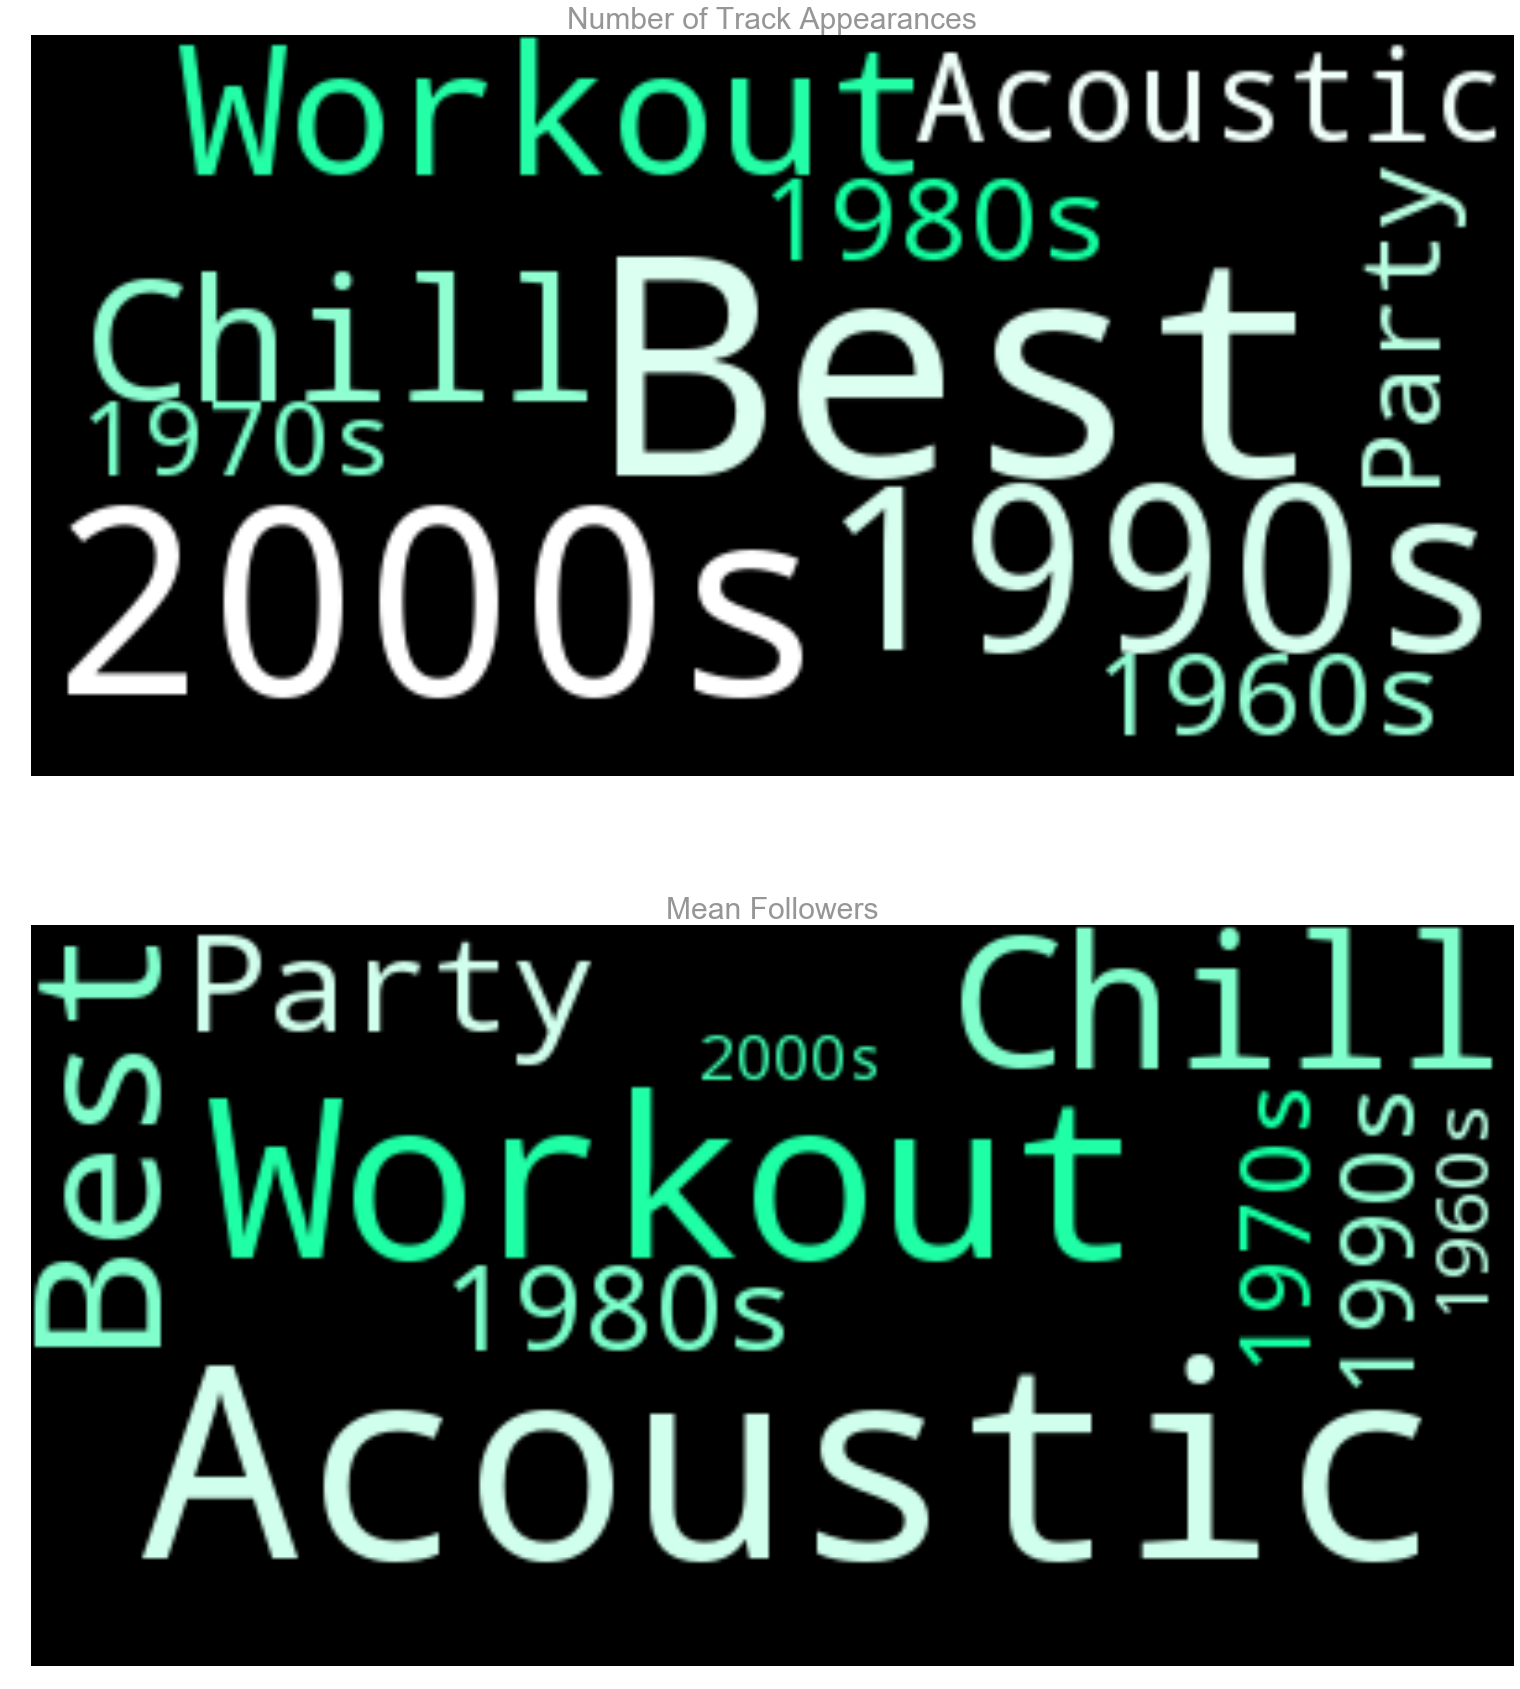

In [57]:
word_cloud()